# Experiment 1-4

Authors: Luisa, Sebastian, Jan-Felix, Nion 


## T5 Model Set-up

In [33]:
import torch
import pandas as pd
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GPT2LMHeadModel, GPT2Tokenizer
import re
import numpy as np
import os
import scipy.stats as stats
import seaborn as sns

In [16]:
##################################################
#LLM Set Up
##################################################

# load the tokenizer & model for T5 & GPT2
tokenizer_T5 = AutoTokenizer.from_pretrained("google/flan-t5-base")
model_T5 = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base",
                                                 pad_token_id=tokenizer_T5.eos_token_id)

tokenizer_GPT2 = GPT2Tokenizer.from_pretrained("gpt2")
model_GPT2 = GPT2LMHeadModel.from_pretrained("gpt2",
                                             pad_token_id=tokenizer_GPT2.eos_token_id)

# convenience function for nicer output
def pretty_print(s):
    print("Output:\n" + 100 * '-')
    print(s)


def generate(prompt, model="T5", **config):
    if model == "T5":
        model = model_T5
        tokenizer = tokenizer_T5
    else:
        model = model_GPT2
        tokenizer = tokenizer_GPT2
    # encode context the generation is conditioned on
    input_ids = tokenizer.encode(prompt, return_tensors='pt')
    
   # default config for generate call
    params = {'do_sample': True,
              'max_length': 500,
              'top_k': 0,
              'top_p': 1,
              'temperature':1,
             }
    # update with config given by user
    params.update(config)
    sample_output = model.generate(input_ids, **params)
    sequences = sample_output['sequences']
    scores = sample_output['scores']
    
    # just to have a look at token probabilities, not used in code
    probs = torch.stack(scores, dim=1).softmax(-1)
    probs, _ = torch.sort(probs, descending=True)
    # print(probs)
    return(tokenizer.decode(sequences[0], skip_special_tokens=True))

## Experiments Set-up T5

In [17]:
###########################################
#Experiment Set-up 
###########################################

def convert_exp1(text):
    """
    :text param: experimental item/sentence
    :output: prompt for model
    """
    text = text.replace(
        "XXX", ". Choose the more likely number:").replace("YYYY", "or")
    text = text+"?"
    return text



def process_stimuli(convert_func, exp_stimuli):
    """
    Processes a stimuli file and extracts "thinks" and "announced" prompts in two sepetate datasets.
    :param convert_func: requires function to convert the prompts as needed.
    :param exp_stimuli: requires a string of experimental txt file 
    :return: List of "thinks" and list of "announced" prompts.
    """
    thinks = []
    announced = []
    all_lines = []
    stimuli_exp1_file = open(exp_stimuli, 'r')
    # open file (from: https://osf.io/9eg34/)

    for l in stimuli_exp1_file.readlines():
        all_lines.append(l)

    for i in range(len(all_lines)//3):

        # in the file, there is always one "thinks" line followed by one "announced" line and one blank line
        line1 = all_lines.pop(0)
        # remove first part since its an identifier
        text1 = " ".join(line1.split()[1:])
        prompt1 = convert_func(text1)
        thinks.append(prompt1)

        line2 = all_lines.pop(0)
        text2 = " ".join(line2.split()[1:])
        prompt2 = convert_func(text2)
        announced.append(prompt2)

        all_lines.pop(0)

    return thinks, announced



def process_stimuli_exp4(convert_func, exp_stimuli):
    """
    Processes a stimuli file for experiment 4.
    :param convert_func: requires function to convert the prompts as needed.
    :param exp_stimuli: requires a string of experimental txt file 
    :return: List of "high", list of "mid", and list of "low" prompts.
    """
    high = []
    mid = []
    low = []
    all_lines = []
    stimuli_exp1_file = open(exp_stimuli, 'r')
    # open file (from: https://osf.io/9eg34/)

    for l in stimuli_exp1_file.readlines():
        all_lines.append(l)

    for i in range(len(all_lines)//4):

        # in the file, there is always one "high" line followed by one "mid" line, on "low" line, and one blank line
        line1 = all_lines.pop(0)
        # remove first part since its an identifier
        text1 = " ".join(line1.split()[1:])
        prompt1 = convert_func(text1)
        high.append(prompt1)

        line2 = all_lines.pop(0)
        text2 = " ".join(line2.split()[1:])
        prompt2 = convert_func(text2)
        mid.append(prompt2)

        line3 = all_lines.pop(0)
        text3 = " ".join(line3.split()[1:])
        prompt3 = convert_func(text3)
        low.append(prompt3)

        all_lines.pop(0)

    return high, mid, low



def extract_number(question, response):
    """This function defines whether the lower or higher or both or neither number of the question is present in the model response 
    """
    qs = question.replace("?", "").split()
    low = qs[-3]
    high = qs[-1]
    has_low = False
    has_high = False
    rs = response.replace(".", "").replace(",", "").split()
    for i in rs:
        if i == low:
            has_low = True
        if i == high:
            has_high = True

    if has_low and has_high:
        return "both"
    elif has_low:
        return "low"
    elif has_high:
        return "high"
    else:
        return "neither"



def get_counts(N, condition1prompts, condition2prompts, model="T5", **config):
    '''Counts the numbers in the model response. 
    :param N: number of participatants i.e. number of repeats for model 
    :param condition1prompts: dataset with e.g. think sentences 
    :param condition2prompts: dataset with e.g. announced sentences
    :param model: LLM model to use 
    :output: condition1_counts and condition2_counts, in the format [counts of both numbers in answer, counts of low number, counts of high, counts of neither]
    '''
    condition1_counts = [0, 0, 0, 0]
    condition2_counts = [0, 0, 0, 0]

    for p in range(N):  # Number of participants in the "think" condition
        print(p)
        for tq in condition1prompts:
            response = generate(tq, model, **config)
            result = extract_number(tq, response)
            if result == "both":
                condition1_counts[0] += 1
            elif result == "low":
                condition1_counts[1] += 1
            elif result == "high":
                condition1_counts[2] += 1
            else:
                condition1_counts[3] += 1

    for p in range(N):  # Number of participants in the "announce" condition
        print(p)
        for aq in condition2prompts:
            response = generate(aq, model, **config)
            # print(aq)
            # print(response)
            result = extract_number(aq, response)
            if result == "both":
                condition2_counts[0] += 1
            elif result == "low":
                condition2_counts[1] += 1
            elif result == "high":
                condition2_counts[2] += 1
            else:
                condition2_counts[3] += 1

    return condition1_counts, condition2_counts


def get_counts_exp4(N, highprompts, midprompts, lowprompts, model="T5", **config):
    '''Counts the numbers in the model response. 
    :param N: number of participatants i.e. number of repeats for model 
    :param highprompts: dataset with highest category sentences 
    :param midprompts: dataset with middle category sentences 
    :param lowprompts: dataset with lowest category sentences 
    :param model: LLM model to use 
    :output: high_counts, mid_counts, and low_counts, in the format [counts of both numbers in answer, counts of low number, counts of high, counts of neither]
    '''
    high_counts = [0, 0, 0, 0]
    mid_counts = [0, 0, 0, 0]
    low_counts = [0, 0, 0, 0]
    
    
    # get counts for each prompt seperately
    high_counts_per_prompt = np.zeros((len(highprompts), 4))
    mid_counts_per_prompt = np.zeros((len(midprompts), 4))
    low_counts_per_prompt = np.zeros((len(lowprompts), 4))



    for p in range(N):  # Number of participants in the "think" condition
        print(p)
        for i, hq in enumerate(highprompts):
            response = generate(hq, model, **config)
            result = extract_number(hq, response)
            if result == "both":
                high_counts[0] += 1
                high_counts_per_prompt[i, 0] += 1
            elif result == "low":
                high_counts[1] += 1
                high_counts_per_prompt[i, 1] += 1

            elif result == "high":
                high_counts[2] += 1
                high_counts_per_prompt[i, 2] += 1

            else:
                high_counts[3] += 1
                high_counts_per_prompt[i, 3] += 1


    for p in range(N):  # Number of participants in the "announce" condition
        print(p)
        for i, mq in enumerate(midprompts):
            response = generate(mq, model, **config)
            result = extract_number(mq, response)
            if result == "both":
                mid_counts[0] += 1
                mid_counts_per_prompt[i, 0] += 1
            elif result == "low":
                mid_counts[1] += 1
                mid_counts_per_prompt[i, 1] += 1
            elif result == "high":
                mid_counts[2] += 1
                mid_counts_per_prompt[i, 2] += 1
            else:
                mid_counts[3] += 1
                mid_counts_per_prompt[i, 3] += 1
                
    for p in range(N):  # Number of participants in the "announce" condition
        print(p)
        for i, lq in enumerate(lowprompts):
            response = generate(lq, model, **config)
            result = extract_number(lq, response)
            if result == "both":
                low_counts[0] += 1
                low_counts_per_prompt[i, 0] += 1
            elif result == "low":
                low_counts[1] += 1
                low_counts_per_prompt[i, 1] += 1
            elif result == "high":
                low_counts[2] += 1
                low_counts_per_prompt[i, 2] += 1
            else:
                low_counts[3] += 1
                low_counts_per_prompt[i, 3] += 1

    return (high_counts, mid_counts, low_counts, high_counts_per_prompt, mid_counts_per_prompt, low_counts_per_prompt)


def get_response(N, condition1prompts, condition2prompts, name_cond1, name_cond2, model="T5"):
    '''Reports the prompt, response and response classifiction (into low, high, both, neither) of the model for N trials
    :param N: number of participatants i.e. number of repeats for model
    :param condition1prompts: dataset with condition 1 sentences as list
    :param condition2prompts: dataset with condition 2 sentences as list
    :param name_cond1: name of condtion that shows up in the output table
    :param condition2prompts: name of condtion that shows up in the output table
    :param model: LLM model to use
    :output: dataframe condition1output and dataframe condition2output
    '''
    condition1output = pd.DataFrame(columns=["Condition", "Prompt", "Response", "Number"])
    condition2output = pd.DataFrame(columns=["Condition", "Prompt", "Response", "Number"])


    for p in range(N):

        for tq in condition1prompts:
            response = generate(tq, model)
            result = extract_number(tq, response)
            row = {"Condition": name_cond1, "Prompt": tq, "Response": response, "Number": result}
            condition1output = pd.concat([condition1output, pd.DataFrame([row])], ignore_index=True)

        for tq in condition2prompts:
            response = generate(tq, model)
            result = extract_number(tq, response)
            row = {"Condition": name_cond2, "Prompt": tq, "Response": response, "Number": result}
            condition2output = pd.concat([condition2output, pd.DataFrame([row])], ignore_index=True)

    return condition1output, condition2output

def count_string_occurrences(dataframe, column_name):
    # Get the counts of each string in the specified column
    string_counts = dataframe[column_name].value_counts()

    # Create a dictionary to store the string counts
    counts = {}

    # Iterate over the unique strings and their counts
    for string, count in string_counts.items():
        counts[string] = count

    return counts



## Experiment 1

### T5 Model

In [18]:
# specify config for calling t5 model here
config = {'do_sample': True,
          'max_length': 500,
          'temperature': 0.5,
           # 'top_k': 0,
          'output_scores': True,
          'return_dict_in_generate': True}

In [21]:
#create dataframe for all counts results: 
results = pd.DataFrame(columns=["Both", "Low", "High", "Neither"])

In [22]:
 #get the prompts for the 2 condtions in 2 lists
thinks, announced = process_stimuli(convert_exp1,"stimuli/stimuli_Exp1.txt")

### Use this code to get the full data frame with prompts and responses
# think_response, announce_response = get_response(N=1,condition1prompts=thinks, condition2prompts= announced, name_cond1="baseline_T5_t", name_cond2="baseline_T5_a")
# think_resp_counts = count_string_occurrences(think_response, "Number")
# announce_resp_counts = count_string_occurrences(announce_response, "Number")

# print("The T5 model in the think condition:",think_resp_counts )
# print("The T5 model in the announce condition:", announce_resp_counts)


### Use this to only get the counts
think_counts, announce_counts = get_counts(N=1,condition1prompts=thinks, condition2prompts= announced, **config)

print("The T5 model in the think condition:", think_counts)
print("The T5 model in the announce condition:", announce_counts)
    
# Append the new row to the Counts_Results DataFrame
results.loc["baseline_T5_t"] = think_counts
results.loc["baseline_T5_a"] = announce_counts

0
0
The T5 model in the think condition: [0, 9, 3, 0]
The T5 model in the announce condition: [0, 6, 5, 1]


In [23]:
data = np.asarray(results[['Low', 'High']])

Here we put in the data manually from the n=400 run, to show the testing. 

In [24]:
data = [[1659, 3067,], [1470, 3232]]

In [25]:
odd_ratio, p_value = stats.fisher_exact(data, alternative='greater')
print('odd ratio is : ' + str(odd_ratio))
print('p_value is : ' + str(p_value))

odd ratio is : 1.1892868787554147
p_value is : 4.100815182942583e-05


### GPT 3.5

In [157]:
import openai
openai.api_key = 'Put your OpenAI API Key here'

In [158]:
thinks, announced = process_stimuli(convert_exp1,"stimuli/stimuli_Exp1.txt")

In [165]:
def get_response_gpt(p, model, n, t):
    response = openai.ChatCompletion.create(
        model=model,
        messages=[
            {"role": "user", "content": p},
        ],
        temperature=t,
        n=n,
        max_tokens=200)
    return response

In [319]:
import time
def get_results_gpt(prompts_cond_1, prompts_cond_2, cond_1_name, cond_2_name, exp_name='', n=1, t=0.5):

    results = pd.DataFrame(columns=["Prompt_ID","Condition", "Prompt", "Response"])
    model = 'gpt-3.5-turbo'


    for p_id in range(len(prompts_cond_1)):
        print(p_id)

        p_1 = prompts_cond_1[p_id]
        p_2 = prompts_cond_2[p_id]
        
        # add instruction for gpt to not talk to much
        ending = ' Answer only with the number.'
        p_1 = p_1 + ending
        p_2 = p_2 + ending

        response_1 = get_response_gpt(p_1, model, n, t)
        response_2 = get_response_gpt(p_2, model, n, t)

        # for large n use sleep to avoid rate limits
        time.sleep(60)

        # create row in dataframe for every reponse option   
        for i in range(len(response_1['choices'])):
            r_text_1 = response_1['choices'][i]['message']['content']
            r_text_2 = response_2['choices'][i]['message']['content']

            row_1 = {"Prompt_ID": p_id, "Condition": cond_1_name, "Prompt": p_1, "Response": r_text_1}
            row_2 = {"Prompt_ID": p_id, "Condition": cond_2_name, "Prompt": p_2, "Response": r_text_2}

            results = pd.concat([results, pd.DataFrame([row_1]), pd.DataFrame([row_2])], ignore_index=True)
    

    file_name = f'{exp_name}_model={model}_n={n}_t={t}'
    os.makedirs('data', exist_ok=True) 
    path = 'data/' + file_name
    results.to_csv(path)
    return results

In [224]:
results_exp1 = get_results_gpt(thinks, announced, 'think', 'announce', n=128)
 

0
1
2
3
4
5
6
7
8
9
10
11


In [27]:
results_exp1 = pd.read_csv('data/exp_1_model=gpt-3.5-turbo_n=128_t=0.5', index_col=0)

In [28]:
# uses extract number function to make new column with one of ['low', 'high', 'both', 'neither']
results_exp1['extracted_n'] = results_exp1.apply(extract_number_gpt, axis=1)
results_exp1

,Prompt_ID,Condition,Prompt,Response,extracted_n
0,0,think,Joseph is a man from the US. Joseph lives next...,8,low
1,0,announce,Joseph is a man from the US. Joseph lives next...,8,low
2,0,think,Joseph is a man from the US. Joseph lives next...,The more likely number is 8.,low
3,0,announce,Joseph is a man from the US. Joseph lives next...,8,low
4,0,think,Joseph is a man from the US. Joseph lives next...,There is not enough information provided to de...,neither
...,...,...,...,...,...
3067,11,announce,Sarah is a woman from the US. Sarah has an acq...,46,low
3068,11,think,Sarah is a woman from the US. Sarah has an acq...,46,low
3069,11,announce,Sarah is a woman from the US. Sarah has an acq...,46,low
3070,11,think,Sarah is a woman from the US. Sarah has an acq...,46,low


In [12]:
counts = results_exp1.groupby('Condition')['extracted_n'].value_counts()
counts

Condition  extracted_n
announce   high           762
           low            618
           neither        127
           both            29
think      low            669
           high           662
           neither        166
           both            39
Name: count, dtype: int64

In [ ]:
c_table = pd.DataFrame(columns=["Announced", "Think"])

c_table.loc['higher'] = [counts['announce']['high'], counts['announce']['low']]
c_table.loc['lower'] =  [counts['think']['high'], counts['think']['low']]

c_table

In [232]:
odd_ratio, p_value = stats.fisher_exact(c_table.values, alternative='greater')
print('odd ratio is : ' + str(odd_ratio))
print('p_value is : ' + str(p_value))

odd ratio is : 1.2460475757486875
p_value is : 0.0024108316531341136


**Analysis per prompt**

In [31]:
n_low = results_exp1[results_exp1['extracted_n'] == 'low'].groupby(['Prompt_ID', 'Condition'])['extracted_n'].count().unstack(fill_value=0).stack()
n_high = results_exp1[results_exp1['extracted_n'] == 'high'].groupby(['Prompt_ID', 'Condition'])['extracted_n'].count().unstack(fill_value=0).stack()

# this is a little ugly but the count function refuses to fill in zeros
n_high.loc[11, 'think'] = 0
n_high.loc[11, 'announce'] = 0

ratio_high = n_high/(n_low + n_high)
r_high_df = pd.DataFrame(ratio_high).reset_index().rename(columns={0: 'ratio_high'})
r_high_df

,Prompt_ID,Condition,ratio_high
0,0,announce,0.000000
1,0,think,0.030303
2,1,announce,0.992188
3,1,think,0.903509
4,2,announce,0.929688
5,2,think,0.984375
6,3,announce,0.648438
7,3,think,0.664062
8,4,announce,0.992000
9,4,think,0.838710


**Rate of choosing high number distributed over prompts** 
Rate depends heavily on prompt. Also on clear trend that the announce condition has always a higher rate

<Axes: xlabel='Prompt_ID', ylabel='ratio_high'>

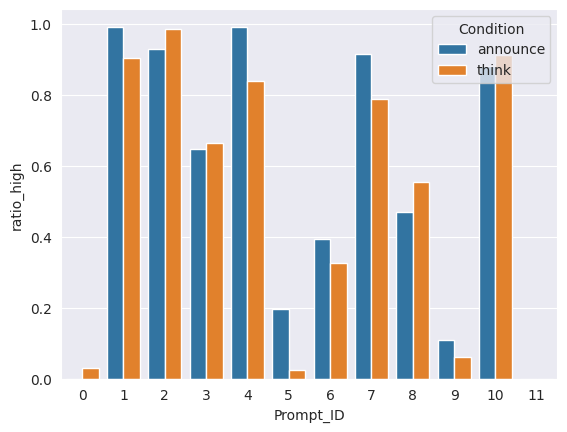

In [36]:
sns.set_style("darkgrid")

sns.barplot(data = r_high_df, x='Prompt_ID', y='ratio_high', hue='Condition')

### Experimentation with few shot learning

In [56]:
##################
#1-shot learning
#################

def convert_oneshot(text):
    """Creates prompt with 1 example before the actual task  
    input: experimental item 
    output: Exmaple + Experimental item Task (Choose the more likely number)
    """
    example1 = "Rachel is a librarian and works with Mark. Mark thinks that Rachel read ___ books last month. Choose the more likely number: 45 or 52. The answer is 45. Rachel is a woman from the US. Rachel is a librarian and works with Mark. Mark announced to me that Rachel read ___ books last month. Choose the more likely number: 45 or 52. The answer is 52. "
    text = text.replace(
        "XXX", ". Choose the more likely number:").replace("YYYY", "or")
    text = example1+text+"?"
    return text

thinks, announced = process_stimuli(convert_oneshot,"stimuli/stimuli_Exp1.txt")

think_counts, announce_counts = get_counts(N=1, condition1prompts=thinks,  condition2prompts=announced, **config)
print("The T5 model in the think condition with 1 shot learning:", think_counts)
print("The T5 model in the announce condition with 1 shot learning", announce_counts)

# Append the new row to the Results DataFrame
results.loc["1shot_T5_t"] = think_counts
results.loc["1shot_T5_a"] = announce_counts

0
0
The T5 model in the think condition with 1 shot learning: [0, 9, 3, 0]
The T5 model in the announce condition with 1 shot learning [0, 7, 5, 0]


In [59]:

##################
#2-shot learning
#################
def convert_twoshot(text):
    """Creates prompt with 2 example before the actual task  
    input: experimental item 
    output: Exmaple + Experimental item Task (Choose the more likely number)
    """
    example1 = "Rachel is a librarian and works with Mark. Mark thinks that Rachel read ___ books last month. Choose the more likely number: 45 or 52. The answer is 45. Rachel is a woman from the US. Rachel is a librarian and works with Mark. Mark announced to me that Rachel read ___ books last month. Choose the more likely number: 45 or 52. The answer is 52."
    example2 = "Alex is a person from the US. Alex works at a cafe with Emma. Emma thinks that Alex drank ___ cups of coffee yesterday. Choose the more likely number: 3 or 5. The answer is 3. Alex is a person from the US. Alex works at a cafe with Emma. Emma announced to me that Alex drank ___ cups of coffee yesterday. Choose the more likely number:  3 or 5. The answer is 5."
    text = text.replace(
        "XXX", ". Choose the more likely number:").replace("YYYY", "or")
    text = example1+example2+text+"?"
    return text

thinks, announced = process_stimuli(convert_twoshot, "stimuli/stimuli_Exp1.txt")
think_counts, announce_counts = get_counts(N=1, condition1prompts=thinks, condition2prompts=announced, **config)
print("The T5 model in the think condition with 2 shot learning:", think_counts)
print("The T5 model in the announce condition with 2 shot learning:", announce_counts)

# Append the new row to the Results DataFrame
results.loc["2shot_T5_t"] = think_counts
results.loc["2shot_T5_a"] = announce_counts


##################
#3-shot learning
#################
def convert_threeshot(text):
    """Creates prompt with 3 example before the actual task  
    input: experimental item 
    output: Exmaple + Experimental item Task (Choose the more likely number)
    """
    example1 = "Rachel is a librarian and works with Mark. Mark thinks that Rachel read ___ books last month. Choose the more likely number: 45 or 52. The answer is 45. Rachel is a woman from the US. Rachel is a librarian and works with Mark. Mark announced to me that Rachel read ___ books last month. Choose the more likely number: 45 or 52. The answer is 52."
    example2 = "Alex is a person from the US. Alex works at a cafe with Emma. Emma thinks that Alex drank ___ cups of coffee yesterday. Choose the more likely number: 3 or 5. The answer is 3. Alex is a person from the US. Alex works at a cafe with Emma. Emma announced to me that Alex drank ___ cups of coffee yesterday. Choose the more likely number:  3 or 5. The answer is 5."
    example3 = "Michael is a man from the US. Michael lives in a hot climate. He thinks that the temperature reached ___ degrees Celsius yesterday.Choose the more likely number: 34 or 40. The answer is 34. Michael is a man from the US. Michael lives in a hot climate. He announced to me that the temperature reached ___ degrees Celsius yesterday. Choose the more likely number:  34 or 40. The answer is 40."
    text = text.replace(
        "XXX", ". Choose the more likely number:").replace("YYYY", "or")
    text = example1+example2+example3+text+"?"
    return text

thinks, announced = process_stimuli(convert_threeshot, "stimuli/stimuli_Exp1.txt")

think_counts, announce_counts = get_counts(N=1, condition1prompts=thinks, condition2prompts=announced, **config)
print("The T5 model in the think condition with 3 shot learning:", think_counts)
print("The T5 model in the announce condition with 3 shot learning:", announce_counts)

# Append the new row to the Results DataFrame
results.loc["3shot_T5_t"] = think_counts
results.loc["3shot_T5_a"] = announce_counts



0
0
The T5 model in the think condition with 2 shot learning: [0, 8, 4, 0]
The T5 model in the announce condition with 2 shot learning: [0, 6, 5, 1]
0
0
The T5 model in the think condition with 3 shot learning: [0, 8, 4, 0]
The T5 model in the announce condition with 3 shot learning: [0, 5, 6, 1]


In [ ]:
##################
#1-shot-extreme learning
#################

def convert_oneshot_extreme(text):
    """Creates prompt with 1 example before the actual task  
    input: experimental item 
    output: Exmaple + Experimental item Task (Choose the more likely number)
    """
    example_e = "Rachel is a librarian and works with Mark. Mark thinks that Rachel read ___ books last month. Choose the more likely number: 11 or 102. The answer is 11. Rachel is a woman from the US. Rachel is a librarian and works with Mark. Mark announced to me that Rachel read ___ books last month. Choose the more likely number: 11 or 102. The answer is 102. "
    text = text.replace(
        "XXX", ". Choose the more likely number:").replace("YYYY", "or")
    text = example_e+text+"?"
    return text

thinks, announced = process_stimuli(convert_oneshot_extreme, "stimuli/stimuli_Exp1.txt")

think_counts, announce_counts = get_counts(N=1, condition1prompts=thinks, condition2prompts=announced, **config)
print("The T5 model in the think condition with 1 extreme shot learning:", think_counts)
print("The T5 model in the announce condition with 1 extreme shot learning", announce_counts)

# Append the new row to the Results DataFrame
results.loc["1shot_extreme_T5_t"] = think_counts
results.loc["1shot_extreme_T5_a"] = announce_counts

In [60]:
###############################
#knowledge generation learning
###############################

#https://www.promptingguide.ai/techniques/knowledge

def convert_know(text):
    """Creates prompt with a infomration before the question  
    input: experimental item 
    output: Exmaple + Experimental item Task (Choose the more likely number)
    """
    knowledge = "Knowledge: the lower number is just slighlty above the mean and the larger number is a lot above the mean."
    text = text.replace(
        "XXX", ". Choose the more likely number:").replace("YYYY", "or")
    text = knowledge+text+"?"
    return text

thinks, announced = process_stimuli(convert_know, "stimuli/stimuli_Exp1.txt")

think_counts, announce_counts = get_counts(N=1, condition1prompts=thinks, condition2prompts=announced, **config)
print("The T5 model in the think condition with knowledge prompting :", think_counts)
print("The T5 model in the announce condition with knowledge prompting:", announce_counts)

# Append the new row to the Results DataFrame
results.loc["know_T5_t"] = think_counts
results.loc["know_T5_a"] = announce_counts

0
0
The T5 model in the think condition with knowledge prompting : [0, 6, 5, 1]
The T5 model in the announce condition with knowledge prompting: [0, 8, 4, 0]


In [11]:
print(results)

                    Both  Low  High  Neither
baseline_T5_t          0   34    21        5
baseline_T5_a          0   37    18        5
1shot_T5_t             0   39    19        2
1shot_T5_a             0   36    23        1
2shot_T5_t             0   38    20        2
2shot_T5_a             0   37    23        0
3shot_T5_t             0   37    20        3
3shot_T5_a             0   36    24        0
1shot_extreme_T5_t     0   42    14        4
1shot_extreme_T5_a     0   35    24        1
know_T5_t              0   28    31        1
know_T5_a              0   33    26        1


## Experiment 2

### T5

In [40]:
#create dataframe for all results of Exp2: 
results_exp2 = pd.DataFrame(columns=["Both", "Low", "High", "Neither"])

In [41]:
def convert_exp2(text):
    """This function converts the experimental item into a prompt.
    :text param: experimental item/sentence
    :output: prompt for model
    """
    text = text.replace("XXX", ". Choose the more likely number:", 1)
    text = text.replace("XXX", "or", 1)
    text = text + "?"
    return text

In [42]:
blue, asked = process_stimuli(convert_exp2, "stimuli/stimuli_Exp2.txt")
blue_counts, asked_counts = get_counts(N=5, condition1prompts=blue, condition2prompts=asked, **config)

print("The T5 model in the out of blue condition:", blue_counts)
print("The T5 model in the when asked condition:", asked_counts)

# Append the new row to the Results DataFrame
results_exp2.loc["exp2_T5_asked"] = asked_counts
results_exp2.loc["exp2_T5_blue"] = blue_counts

0
1
2
3
4
0
1
2
3
4
The T5 model in the out of blue condition: [0, 110, 54, 6]
The T5 model in the when asked condition: [0, 121, 44, 5]


In [ ]:
# manually putting in the data from the n=400 run
data_df = pd.DataFrame(columns=["Blue", "Asked"])
data_df.loc['high'] = [4246, 4616] 
data_df.loc['low'] = [8990, 8652]
data = data_df.values
data_df

In [ ]:
odd_ratio, p_value = stats.fisher_exact(data, alternative='greater')
print('odd ratio is : ' + str(odd_ratio))
print('p_value is : ' + str(p_value))

### GPT 3.5

In [312]:
blue, asked = process_stimuli(convert_exp2, "stimuli/stimuli_Exp2.txt")
results_exp2 = get_results_gpt(asked, blue, 'asked', 'blue', exp_name='exp2', n=128)
results_exp2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


,Prompt_ID,Condition,Prompt,Response
0,0,asked,Joseph is a man from the US. Joseph has a girl...,9
1,0,blue,Joseph is a man from the US. Joseph has a girl...,The more likely number is 6.
2,0,asked,Joseph is a man from the US. Joseph has a girl...,6
3,0,blue,Joseph is a man from the US. Joseph has a girl...,9
4,0,asked,Joseph is a man from the US. Joseph has a girl...,There is not enough information provided to de...
...,...,...,...,...
8699,33,blue,Rob and Wendy are a couple from the US. Rob an...,The more likely number would be 8.
8700,33,asked,Rob and Wendy are a couple from the US. Rob an...,8
8701,33,blue,Rob and Wendy are a couple from the US. Rob an...,The more likely number is 8.
8702,33,asked,Rob and Wendy are a couple from the US. Rob an...,8


In [313]:
results_exp2['extracted_n'] = results_exp2.apply(extract_number_gpt, axis=1)
results_exp2

,Prompt_ID,Condition,Prompt,Response,extracted_n
0,0,asked,Joseph is a man from the US. Joseph has a girl...,9,high
1,0,blue,Joseph is a man from the US. Joseph has a girl...,The more likely number is 6.,low
2,0,asked,Joseph is a man from the US. Joseph has a girl...,6,low
3,0,blue,Joseph is a man from the US. Joseph has a girl...,9,high
4,0,asked,Joseph is a man from the US. Joseph has a girl...,There is not enough information provided to de...,both
...,...,...,...,...,...
8699,33,blue,Rob and Wendy are a couple from the US. Rob an...,The more likely number would be 8.,low
8700,33,asked,Rob and Wendy are a couple from the US. Rob an...,8,low
8701,33,blue,Rob and Wendy are a couple from the US. Rob an...,The more likely number is 8.,low
8702,33,asked,Rob and Wendy are a couple from the US. Rob an...,8,low


In [315]:
counts = results_exp2.groupby('Condition')['extracted_n'].value_counts()
counts

Condition  extracted_n
asked      neither        1399
           low            1340
           high           1240
           both            373
blue       low            1428
           high           1356
           neither        1214
           both            354
Name: count, dtype: int64

In [316]:
counts = results_exp2.groupby('Condition')['extracted_n'].value_counts()
c_table = pd.DataFrame(columns=["blue", "asked"])

c_table.loc['higher'] = [counts['blue']['high'], counts['blue']['low']]
c_table.loc['lower'] =  [counts['asked']['high'], counts['asked']['low']]

c_table

,blue,asked
higher,1356,1428
lower,1240,1340


In [317]:
odd_ratio, p_value = stats.fisher_exact(c_table.values, alternative='greater')
print('odd ratio is : ' + str(odd_ratio))
print('p_value is : ' + str(p_value))

odd ratio is : 1.026158850637029
p_value is : 0.3282134903067207


## Experiment 3

### Test results 

T5 Model

note: there is a double enter in the stimuli data (after the 24th item set) which needs to be removed, otherwise the follwing will nut work. (Is removed in the version on github)

In [22]:
results_exp3 = pd.DataFrame(columns=["Both", "Low", "High", "Neither"])

In [318]:
def convert_exp3(text):
    """This function converts the experimental item into a prompt.
    :text param: experimental item/sentence
    :output: prompt for model
    """
    text = text.replace("XXX", ". Choose the more likely number:", 1)
    text = text.replace("XXX", "or", 1)
    text = text #+ "?"
    return text

In [23]:
everyone, me = process_stimuli(convert_exp3, "stimuli/stimuli_Exp3.txt")
everyone_counts, me_counts = get_counts(N=400, condition1prompts=everyone[:], condition2prompts=me[:], **config)

print("The T5 model in the everyone condition:", everyone_counts)
print("The T5 model in the me condition:", me_counts)

# Append the new row to the Results DataFrame
results_exp3.loc["exp3_T5_everyone"] = everyone_counts
results_exp3.loc["exp3_T5_me"] = me_counts

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [81]:
data_df = pd.DataFrame(columns=["Everyone", "Me"])
data_df.loc['high'] = [3656, 3625] 
data_df.loc['low'] = [9385, 9392]
data = data_df.values
data_df

,Everyone,Me
high,3656,3625
low,9385,9392


In [43]:
# data = np.asarray(results_exp3[['Low', 'High']])
odd_ratio, p_value = stats.fisher_exact(data, alternative='greater')
print('odd ratio is : ' + str(odd_ratio))
print('p_value is : ' + str(p_value))

odd ratio is : 1.1892868787554147
p_value is : 4.100815182942583e-05


### GPT 3.5

In [320]:
everyone, me = process_stimuli(convert_exp3, "stimuli/stimuli_Exp3.txt")
results_exp3 = get_results_gpt(me, everyone, 'me', 'everyone', exp_name='exp3', n=128)
results_exp3

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


,Prompt_ID,Condition,Prompt,Response
0,0,me,Joseph is a man from the US. Joseph has a girl...,9
1,0,everyone,Joseph is a man from the US. Joseph has a girl...,9
2,0,me,Joseph is a man from the US. Joseph has a girl...,9
3,0,everyone,Joseph is a man from the US. Joseph has a girl...,9
4,0,me,Joseph is a man from the US. Joseph has a girl...,9
...,...,...,...,...
8699,33,everyone,Rob and Wendy are a couple from the US. Rob an...,The more likely number of chairs that Rob and ...
8700,33,me,Rob and Wendy are a couple from the US. Rob an...,Since the number of chairs owned by Rob and We...
8701,33,everyone,Rob and Wendy are a couple from the US. Rob an...,The answer could be either 8 or 12.
8702,33,me,Rob and Wendy are a couple from the US. Rob an...,Since the given information does not provide a...


In [321]:
results_exp3['extracted_n'] = results_exp3.apply(extract_number_gpt, axis=1)
results_exp3

,Prompt_ID,Condition,Prompt,Response,extracted_n
0,0,me,Joseph is a man from the US. Joseph has a girl...,9,high
1,0,everyone,Joseph is a man from the US. Joseph has a girl...,9,high
2,0,me,Joseph is a man from the US. Joseph has a girl...,9,high
3,0,everyone,Joseph is a man from the US. Joseph has a girl...,9,high
4,0,me,Joseph is a man from the US. Joseph has a girl...,9,high
...,...,...,...,...,...
8699,33,everyone,Rob and Wendy are a couple from the US. Rob an...,The more likely number of chairs that Rob and ...,low
8700,33,me,Rob and Wendy are a couple from the US. Rob an...,Since the number of chairs owned by Rob and We...,both
8701,33,everyone,Rob and Wendy are a couple from the US. Rob an...,The answer could be either 8 or 12.,both
8702,33,me,Rob and Wendy are a couple from the US. Rob an...,Since the given information does not provide a...,both


In [322]:
counts = results_exp3.groupby('Condition')['extracted_n'].value_counts()
counts

Condition  extracted_n
everyone   neither        1206
           low            1078
           high           1075
           both            993
me         neither        1176
           both           1119
           high           1091
           low             966
Name: count, dtype: int64

In [323]:
c_table = pd.DataFrame(columns=["everyone", "me"])

c_table.loc['higher'] = [counts['everyone']['high'], counts['everyone']['low']]
c_table.loc['lower'] =  [counts['me']['high'], counts['me']['low']]

c_table

,everyone,me
higher,1075,1078
lower,1091,966


In [336]:
odd_ratio, p_value = stats.fisher_exact(c_table.values, alternative='greater')
print('odd ratio is : ' + str(odd_ratio))
print('p_value is : ' + str(p_value))

odd ratio is : 0.8829621341078719
p_value is : 0.9797189853041


## Experiment 4

### Test results

T5 Model

In [44]:
 def convert_exp4(text):
    """This function converts the experimental item into a prompt.
    :text param: experimental item/sentence
    :output: prompt for model
    """
    text = text.replace("XXX", " Choose the more likely number:", 1)
    text = text.replace("XXX", "or", 1)
    text = text #+ "?"
    return text

In [140]:
# create dataframe for all results of Exp4:
results_exp4 = pd.DataFrame(columns=["Both", "Low", "High", "Neither"])

In [141]:
high, mid, low = process_stimuli_exp4(convert_exp4, "stimuli/stimuli_Exp4.txt")
high_counts, mid_counts, low_counts, hc_per_prompt, mc_per_prompt, lc_per_prompt = get_counts_exp4(N=100,
                                                highprompts=high[:], midprompts=mid[:], lowprompts=low[:], **config)

print("The T5 model in the high condition:", high_counts)
print("The T5 model in the mid condition:", mid_counts)
print("The T5 model in the low condition:", low_counts)

# Append the new rows to the Results DataFrame
results_exp4.loc["exp4_T5_high"] = high_counts
results_exp4.loc["exp4_T5_mid"] = mid_counts
results_exp4.loc["exp4_T5_low"] = low_counts

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
The T5 model in the high condition: [0, 3038, 913, 149]
The T5 model in the mid condition: [0, 3068, 902, 130]
The T5 model in the

In [45]:
# manual input from n=400 run
data_df = pd.DataFrame(columns=["high", "mid", "low"])
data_df.loc['higher'] = [3617, 3661, 4013] 
data_df.loc['lower'] = [12187, 12163, 11811]

In [46]:
# test high vs mid
data = data_df[['high', 'mid']].values
odd_ratio, p_value = stats.fisher_exact(data, alternative='greater')
print('Test: High vs Mid')
print('odd ratio is : ' + str(odd_ratio))
print('p_value is : ' + str(p_value))
# test mid vs low
data = data_df[['mid', 'low']].values
odd_ratio, p_value = stats.fisher_exact(data, alternative='greater')
print('Test: Mid vs Low')
print('odd ratio is : ' + str(odd_ratio))
print('p_value is : ' + str(p_value))

Test: High vs Mid
odd ratio is : 0.9860357825954806
p_value is : 0.7052903917901425
Test: Mid vs Low
odd ratio is : 0.8858833349699475
p_value is : 0.9999981757016462


In [143]:
df_lc = pd.DataFrame({'low': lc_per_prompt[:, 1], 'high': lc_per_prompt[:, 2]})
df_lc['ratio_high'] = df_lc['high']/ (df_lc['low'] + df_lc['high'])
df_lc = df_lc.reset_index().rename(columns={'index': 'prompt_id'})
df_lc['condition'] = 'low'


df_mc = pd.DataFrame({'low': mc_per_prompt[:, 1], 'high': mc_per_prompt[:, 2]})
df_mc['ratio_high'] = df_mc['high']/ (df_mc['low'] + df_mc['high'])
df_mc = df_mc.reset_index().rename(columns={'index': 'prompt_id'})
df_mc['condition'] = 'mid'


df_hc = pd.DataFrame({'low': hc_per_prompt[:, 1], 'high': hc_per_prompt[:, 2]})
df_hc['ratio_high'] = df_hc['high']/ (df_hc['low'] + df_hc['high'])
df_hc = df_hc.reset_index().rename(columns={'index': 'prompt_id'})
df_hc['condition'] = 'high'

df_all = pd.concat([df_lc, df_mc, df_hc], ignore_index=True)
df_all

,prompt_id,low,high,ratio_high,condition
0,0,75.0,24.0,0.242424,low
1,1,11.0,64.0,0.853333,low
2,2,93.0,7.0,0.070000,low
3,3,60.0,35.0,0.368421,low
4,4,26.0,73.0,0.737374,low
...,...,...,...,...,...
118,36,34.0,66.0,0.660000,high
119,37,92.0,5.0,0.051546,high
120,38,23.0,77.0,0.770000,high
121,39,100.0,0.0,0.000000,high


<Axes: xlabel='prompt_id', ylabel='ratio_high'>

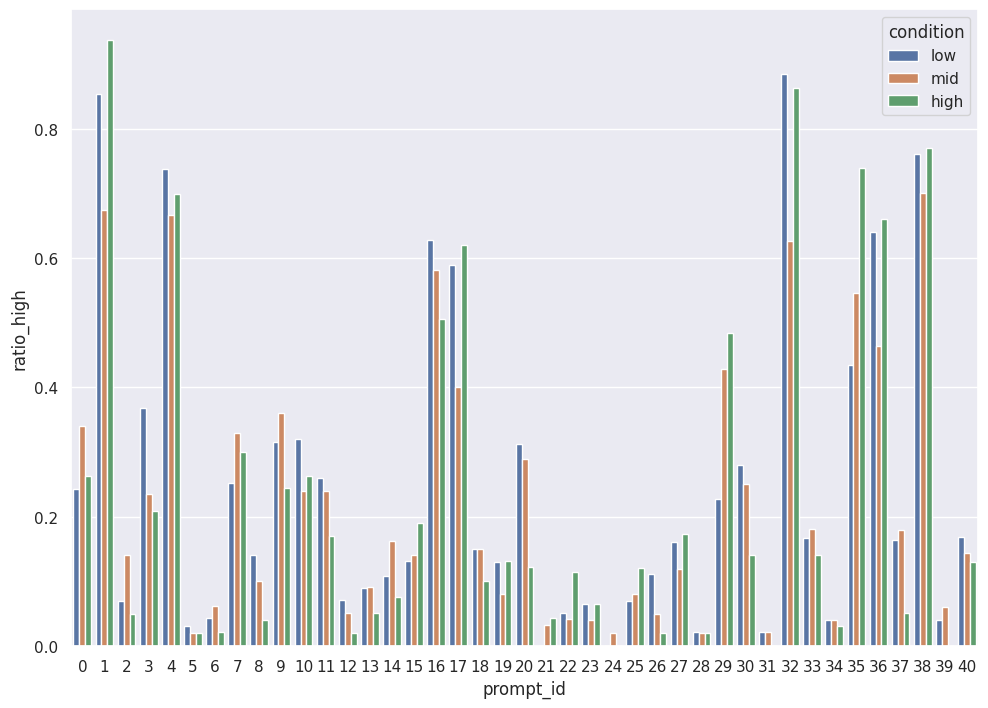

In [146]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data = df_all, x='prompt_id', y='ratio_high', hue='condition')

Check which prompts of the low condition have a high rate of the higher number.
In the low condition there are two types of prompts
1. when asked about it, Anton said
2.  Gregory thinks

In [147]:
idcs_high_ratio = df_lc[df_lc['ratio_high'] > 0.4]['prompt_id'].values
idcs_high_ratio

array([ 1,  4, 16, 17, 32, 35, 36, 38])

In [148]:
print(np.asarray(low)[idcs_high_ratio])

['John is a man from the US. John lives in the same apartment building as Anton. About an hour ago, when asked about it, Anton said that John drank __ beers last month. Choose the more likely number: 22 or 39'
 'Scott is a 12-year-old boy from the US. Scott has a classmate, Matt. Matt thinks that Scott ate __ candy bars last month. Choose the more likely number: 9 or 14'
 'Sidney is a man from the US. Sidney has a brother, Jim. A few days ago, when asked about it, Jim said that Sidney receives __ emails each day. Choose the more likely number: 17 or 32'
 'George is a single 30-year-old man from the US. George has a cousin, Gregory. Gregory thinks that George has been on __ first dates in his life. Choose the more likely number: 15 or 32'
 'Ryan is a 50-year-old man from the US. Ryan has a golf buddy, Chris. Chris thinks that Ryan has received a speeding ticket __ times in his life. Choose the more likely number: 7 or 16'
 'Ralph is a man from the US. Ralph has an uncle, Harry. Harry th

It's an equal distribution of the two types of prompt. That does not seem to be the reason

### GPT 3.5

In [348]:
def get_results_gpt_exp4(prompts_cond_1, prompts_cond_2, prompts_cond_3,
                         cond_1_name, cond_2_name, cond_3_name, n=1, t=0.5):

    results = pd.DataFrame(columns=["Prompt_ID","Condition", "Prompt", "Response"])
    model = 'gpt-3.5-turbo'


    for p_id in range(len(prompts_cond_1)):
        print(p_id)

        p_1 = prompts_cond_1[p_id]
        p_2 = prompts_cond_2[p_id]
        p_3 = prompts_cond_3[p_id]

        # add instruction for gpt to not talk to much
        ending = ' Answer only with the number.'
        p_1 = p_1 + ending
        p_2 = p_2 + ending
        p_3 = p_3 + ending

        responses = []
        for p in (p_1, p_2, p_3):
            i = 1
            done = False
            while(not done):           
                try:
                    response = get_response_gpt(p, model, n, t)
                    responses.append(response)
                    done = True

                except openai.error.RateLimitError as e:
                    print('Caught:')
                    print(e)
                    print(f'sleeping for {i*60} seconds')
                    time.sleep(i*60)
                    i += 1
                    pass
 
        time.sleep(60) # for large n use sleep to aboid rate limits

        response_1 = responses[0]
        response_2 = responses[1]
        response_3 = responses[2]

        
        # create row in dataframe for every reponse option   
        for i in range(len(response_1['choices'])):
            r_text_1 = response_1['choices'][i]['message']['content']
            r_text_2 = response_2['choices'][i]['message']['content']
            r_text_3 = response_3['choices'][i]['message']['content']


            row_1 = {"Prompt_ID": p_id, "Condition": cond_1_name, "Prompt": p_1, "Response": r_text_1}
            row_2 = {"Prompt_ID": p_id, "Condition": cond_2_name, "Prompt": p_2, "Response": r_text_2}
            row_3 = {"Prompt_ID": p_id, "Condition": cond_3_name, "Prompt": p_3, "Response": r_text_3}

            results = pd.concat([results, pd.DataFrame([row_1]), pd.DataFrame([row_2]), pd.DataFrame([row_3])], 
                                ignore_index=True)
    

    file_name = f'exp4_model={model}_n={n}_t={t}'
    os.makedirs('data', exist_ok=True) 
    path = 'data/' + file_name
    results.to_csv(path)
    return results

In [349]:
high, mid, low = process_stimuli_exp4(convert_exp4, "stimuli/stimuli_Exp4.txt")
results_exp4 = get_results_gpt_exp4(high, mid, low, 'high', 'mid', 'low', n=128)
results_exp4


0
1
Caught:
Rate limit reached for default-gpt-3.5-turbo in organization org-J7WwvVWqZ6i4ZKRHBbpdi90k on tokens per min. Limit: 90000 / min. Current: 57644 / min. Contact us through our help center at help.openai.com if you continue to have issues.
sleeping for 60 seconds
2
3
Caught:
Rate limit reached for default-gpt-3.5-turbo in organization org-J7WwvVWqZ6i4ZKRHBbpdi90k on tokens per min. Limit: 90000 / min. Current: 57771 / min. Contact us through our help center at help.openai.com if you continue to have issues.
sleeping for 60 seconds
4
Caught:
Rate limit reached for default-gpt-3.5-turbo in organization org-J7WwvVWqZ6i4ZKRHBbpdi90k on tokens per min. Limit: 90000 / min. Current: 60531 / min. Contact us through our help center at help.openai.com if you continue to have issues.
sleeping for 60 seconds
5
6
Caught:
Rate limit reached for default-gpt-3.5-turbo in organization org-J7WwvVWqZ6i4ZKRHBbpdi90k on tokens per min. Limit: 90000 / min. Current: 60314 / min. Contact us through o

,Prompt_ID,Condition,Prompt,Response
0,0,high,Mary is a woman from the US. Mary lives next d...,"As an AI language model, I do not have access ..."
1,0,mid,Mary is a woman from the US. Mary lives next d...,8
2,0,low,Mary is a woman from the US. Mary lives next d...,8
3,0,high,Mary is a woman from the US. Mary lives next d...,8
4,0,mid,Mary is a woman from the US. Mary lives next d...,"Based on the given information, there is no wa..."
...,...,...,...,...
15739,40,mid,Roy and Emma are a couple from the US. Roy and...,The more likely number of windows in Roy and E...
15740,40,low,Roy and Emma are a couple from the US. Roy and...,It is more likely that Roy and Emma have 8 win...
15741,40,high,Roy and Emma are a couple from the US. Roy and...,It is not possible to determine the more likel...
15742,40,mid,Roy and Emma are a couple from the US. Roy and...,"Based on the given information, it is not poss..."


In [48]:
results_exp4 = pd.read_csv('data/exp4_model=gpt-3.5-turbo_n=128_t=0.5', index_col=0)

In [49]:
results_exp4['extracted_n'] = results_exp4.apply(extract_number_gpt, axis=1)
results_exp4

,Prompt_ID,Condition,Prompt,Response,extracted_n
0,0,high,Mary is a woman from the US. Mary lives next d...,"As an AI language model, I do not have access ...",neither
1,0,mid,Mary is a woman from the US. Mary lives next d...,8,low
2,0,low,Mary is a woman from the US. Mary lives next d...,8,low
3,0,high,Mary is a woman from the US. Mary lives next d...,8,low
4,0,mid,Mary is a woman from the US. Mary lives next d...,"Based on the given information, there is no wa...",both
...,...,...,...,...,...
15739,40,mid,Roy and Emma are a couple from the US. Roy and...,The more likely number of windows in Roy and E...,both
15740,40,low,Roy and Emma are a couple from the US. Roy and...,It is more likely that Roy and Emma have 8 win...,both
15741,40,high,Roy and Emma are a couple from the US. Roy and...,It is not possible to determine the more likel...,low
15742,40,mid,Roy and Emma are a couple from the US. Roy and...,"Based on the given information, it is not poss...",both


In [50]:
counts = results_exp4.groupby('Condition')['extracted_n'].value_counts()
counts

Condition  extracted_n
high       neither        1934
           low            1274
           both           1115
           high            925
low        neither        1855
           low            1681
           high           1084
           both            628
mid        neither        1810
           low            1464
           high           1264
           both            710
Name: count, dtype: int64

In [356]:
c_table = pd.DataFrame(columns=['high', 'mid', 'low'])
c_table.loc['higher'] = [counts['high']['high'], counts['mid']['high'], counts['low']['high']]
c_table.loc['lower'] =  [counts['high']['low'], counts['mid']['low'], counts['low']['low']]
c_table

,high,mid,low
higher,925,1264,1084
lower,1274,1464,1681


In [358]:
data = c_table[['high', 'mid']].values
odd_ratio, p_value = stats.fisher_exact(data, alternative='greater')
print('Test: High vs Mid')
print('odd ratio is : ' + str(odd_ratio))
print('p_value is : ' + str(p_value))
# test mid vs low
data = c_table[['mid', 'low']].values
odd_ratio, p_value = stats.fisher_exact(data, alternative='greater')
print('Test: Mid vs Low')
print('odd ratio is : ' + str(odd_ratio))
print('p_value is : ' + str(p_value))

Test: High vs Mid
odd ratio is : 0.8409425113765078
p_value is : 0.9987716516572392
Test: Mid vs Low
odd ratio is : 1.3388885528199543
p_value is : 5.314439628775802e-08


In [359]:
c_table.loc['higher']/c_table.loc['lower']

high    0.726060
mid     0.863388
low     0.644854
dtype: float64

In [52]:
n_low = results_exp4[results_exp4['extracted_n'] == 'low'].groupby(['Prompt_ID', 'Condition'])['extracted_n'].count().unstack(fill_value=0).stack()
n_high = results_exp4[results_exp4['extracted_n'] == 'high'].groupby(['Prompt_ID', 'Condition'])['extracted_n'].count().unstack(fill_value=0).stack()
ratio_high = n_high/(n_low + n_high)
r_high_df = pd.DataFrame(ratio_high).reset_index().rename(columns={0: 'ratio_high'})
r_high_df

,Prompt_ID,Condition,ratio_high
0,0,high,0.217391
1,0,low,0.000000
2,0,mid,0.022222
3,1,high,0.121212
4,1,low,0.333333
...,...,...,...
115,39,low,1.000000
116,39,mid,1.000000
117,40,high,0.083333
118,40,low,0.027027


Again a wide distribution of rates over the prompts

<Axes: xlabel='Prompt_ID', ylabel='ratio_high'>

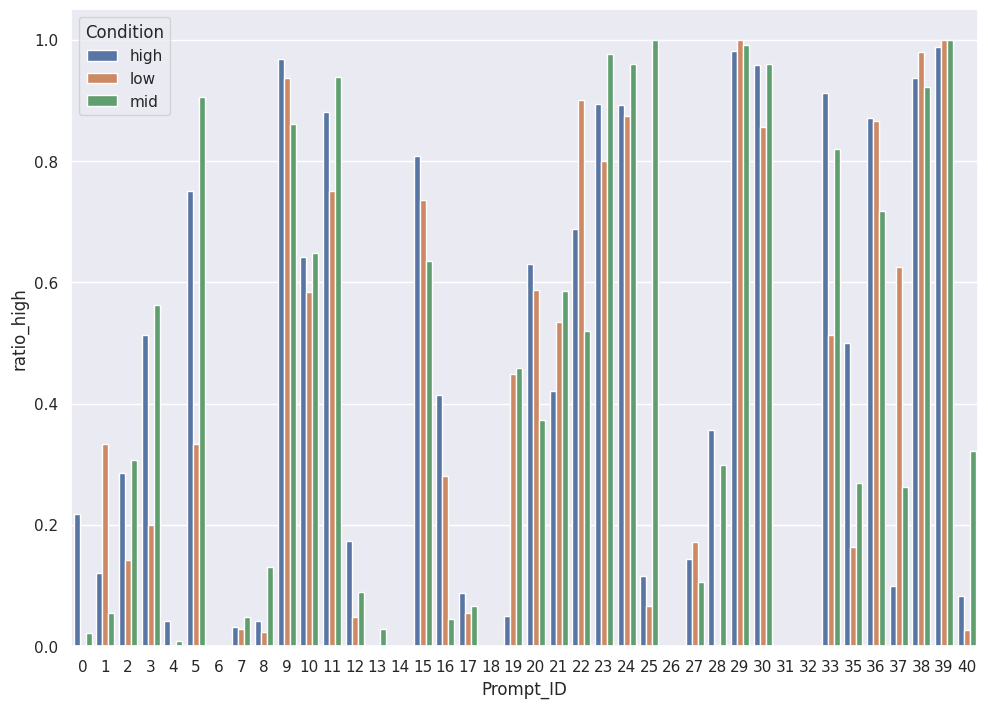

In [54]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.barplot(data = r_high_df, x='Prompt_ID', y='ratio_high', hue='Condition')